In [8]:
import pandas as pd
import numpy as np
from pathlib2 import Path
import matplotlib.pyplot as plt
from typing import List, Tuple, Optional
import re
import lightgbm as lgb
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
path = Path('../../../data/2021_evraz')

In [4]:
target_train = pd.read_pickle(path.joinpath('target_train_wo_gas_wo_sip.pkl'))
print(target_train.shape)
target_train.head(3)

(2063, 145)


,NPLV,TST,C,VES,T,SI,MN,S,P,CR,...,plavka_TIPE_FUR_koniceskaa,plavka_TIPE_FUR_zilindriceskaa,plavka_TIPE_GOL_4-soplh54,plavka_TIPE_GOL_4-soplx54,plavka_TIPE_GOL_5soplovaa,plavka_TIPE_GOL_601-5,plavka_TIPE_GOL_E32,plavka_TIPE_GOL_E37_4-soplh54,plavka_TIPE_GOL_E_4-soplh54,pol_ras_sum
0,510008,1690,0.060,263700.0,1396.0,0.44,0.22,0.023,0.097,0.03,...,0,1,0,0,1,0,0,0,0,593045.405789
1,510009,1683,0.097,264500.0,1419.0,0.68,0.20,0.017,0.087,0.02,...,0,1,0,0,1,0,0,0,0,567680.040137
2,510010,1662,0.091,263800.0,1384.0,0.56,0.26,0.017,0.096,0.03,...,0,1,0,0,1,0,0,0,0,591476.261946


In [5]:
test = pd.read_pickle(path.joinpath('test_wo_gas_wo_sip.pkl'))
print(test.shape)
test.head(3)

(780, 143)


,NPLV,VES,T,SI,MN,S,P,CR,NI,CU,...,plavka_TIPE_FUR_koniceskaa,plavka_TIPE_FUR_zilindriceskaa,plavka_TIPE_GOL_4-soplh54,plavka_TIPE_GOL_4-soplx54,plavka_TIPE_GOL_5soplovaa,plavka_TIPE_GOL_601-5,plavka_TIPE_GOL_E32,plavka_TIPE_GOL_E37_4-soplh54,plavka_TIPE_GOL_E_4-soplh54,pol_ras_sum
0,512324,240100.0,1355.0,0.46,0.33,0.027,0.079,0.01,0.01,0.02,...,0,1,1,0,0,0,0,0,0,463015.154170
1,512327,266400.0,1390.0,0.30,0.33,0.032,0.099,0.01,0.00,0.00,...,0,1,1,0,0,0,0,0,0,499984.992640
2,512328,270200.0,1373.0,0.00,0.00,0.000,0.000,0.00,0.00,0.00,...,0,1,1,0,0,0,0,0,0,468358.082766


Training until validation scores don't improve for 1000 rounds
[25]	train's rmse: 14.4279	train's l2: 208.164	test T's rmse: 23.3143	test T's l2: 543.555
[50]	train's rmse: 10.6786	train's l2: 114.033	test T's rmse: 22.9779	test T's l2: 527.984
[75]	train's rmse: 8.24427	train's l2: 67.968	test T's rmse: 22.9208	test T's l2: 525.365
[100]	train's rmse: 6.58623	train's l2: 43.3785	test T's rmse: 22.8306	test T's l2: 521.238
Did not meet early stopping. Best iteration is:
[100]	train's rmse: 6.58623	train's l2: 43.3785	test T's rmse: 22.8306	test T's l2: 521.238
Training until validation scores don't improve for 1000 rounds
[25]	train's rmse: 0.0530782	train's l2: 0.00281729	test C's rmse: 0.0543015	test C's l2: 0.00294866
[50]	train's rmse: 0.0405486	train's l2: 0.00164419	test C's rmse: 0.0549653	test C's l2: 0.00302118
[75]	train's rmse: 0.0327118	train's l2: 0.00107006	test C's rmse: 0.0558707	test C's l2: 0.00312153
[100]	train's rmse: 0.0272586	train's l2: 0.000743033	test C's rmse

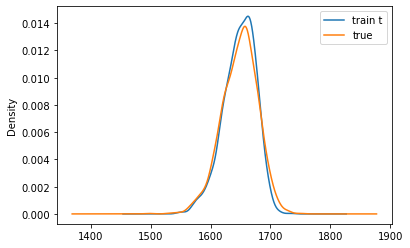


 Распределения истинных и предсказанных данных T на тесте


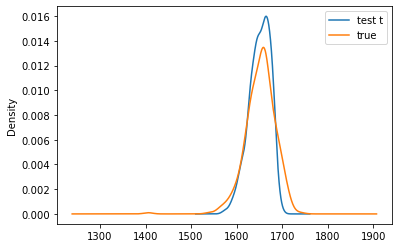


 Распределения истинных и предсказанных данных C на трейне


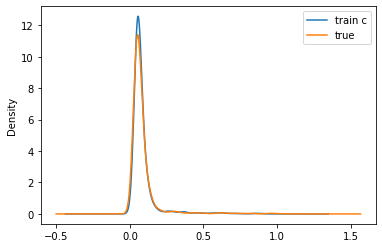


 Распределения истинных и предсказанных данных C на тесте


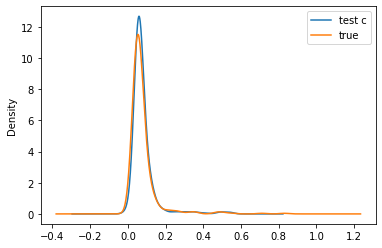

In [23]:
X_train, X_valid = train_test_split(
    target_train.drop(['TST', 'C', 'DATA_ZAMERA'], axis=1), train_size=0.8, random_state=1)
    
y_train_t, y_valid_t = train_test_split(
    target_train['TST'], train_size=0.8, random_state=1)
    
y_train_c, y_valid_c = train_test_split(
    target_train['C'], train_size=0.8, random_state=1)

y_train_true_c, y_valid_true_c = train_test_split(
    target_train['C'], train_size=0.8, random_state=1)

y_train_true_t, y_valid_true_t = train_test_split(
    target_train['TST'], train_size=0.8, random_state=1)

lgb_params = { 
#     'boosting_type': 'gbdt',
#     'n_estimators': 10000,
#     'learning_rate': 0.05134, # default = 0.1, constraints: learning_rate > 0.0
#     'num_leaves': 10, # default = 31
#     'min_data_in_leaf':10000, # default = 20
#     'feature_fraction':0.1, # default = 1.0, constraints: 0.0 < feature_fraction <= 1.0
#     'max_depth': 10,
#     'subsample_for_bin': 240000,
#     'lambda_l1': 2,
#     'lambda_l2': 0,
#     'colsample_bytree': 0.508716,
#     'min_split_gain': 0.024766,
#     'subsample': 0.7,
#     'is_unbalance': False,
     'random_state': 27,
     'silent': -1,
     'verbose': -1
}

model_t = lgb.LGBMRegressor(**lgb_params)
model_c = lgb.LGBMRegressor(**lgb_params)
model_t.fit(
    X=X_train, 
    y=y_train_t,
    eval_set=[(X_train, y_train_t), (X_valid, y_valid_t)],
    eval_names=["train", "test T"],
    early_stopping_rounds=1000,
    eval_metric='rmse',
    verbose=25
)
model_c.fit(
    X=X_train, 
    y=y_train_c,
    eval_set=[(X_train, y_train_c), (X_valid, y_valid_c)],
    eval_names=["train", "test C"],
    early_stopping_rounds=1000,
    eval_metric='rmse',
    verbose=25
)
# metric from https://lightgbm.readthedocs.io/en/latest/Parameters.html#metric
# eval_metric could be taken from: https://xgboost.readthedocs.io/en/latest/parameter.html
# or  https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters

train_predictions_t, test_predictions_t = pd.DataFrame(), pd.DataFrame()
train_predictions_c, test_predictions_c = pd.DataFrame(), pd.DataFrame()

train_predictions_t = model_t.predict(X_train)
test_predictions_t = model_t.predict(X_valid)

train_predictions_c = model_c.predict(X_train)
test_predictions_c = model_c.predict(X_valid)

# график
print('\n Распределения истинных и предсказанных данных T на трейне')
ax =  pd.Series(train_predictions_t).plot.kde(label='train t')
pd.Series(y_train_t).plot.kde(ax=ax, label='true')
plt.legend()
plt.show();

# график
print('\n Распределения истинных и предсказанных данных T на тесте')
ax =  pd.Series(test_predictions_t).plot.kde(label='test t')
pd.Series(y_valid_t).plot.kde(ax=ax, label='true')
plt.legend()
plt.show();

# график
print('\n Распределения истинных и предсказанных данных C на трейне')
ax =  pd.Series(train_predictions_c).plot.kde(label='train c')
pd.Series(y_train_c).plot.kde(ax=ax, label='true')
plt.legend()
plt.show();

# график
print('\n Распределения истинных и предсказанных данных C на тесте')
ax =  pd.Series(test_predictions_c).plot.kde(label='test c')
pd.Series(y_valid_c).plot.kde(ax=ax, label='true')
plt.legend()
plt.show();

In [24]:
train_predictions_t = model_t.predict(X_train)
test_predictions_t = model_t.predict(X_valid)

train_predictions_c = model_c.predict(X_train)
test_predictions_c = model_c.predict(X_valid)

In [25]:
test_t = model_t.predict(test.drop(['DATA_ZAMERA'], axis=1))
test_c = model_c.predict(test.drop(['DATA_ZAMERA'], axis=1))

In [26]:
answers = pd.concat([pd.Series(y_valid_true_t).rename('TST'), 
                     pd.Series(y_valid_true_c).rename('C')
                   ],
                   axis=1
                  )
answers.head(2)

,TST,C
1944,1684,0.037
56,1666,0.056


In [27]:
predictions = pd.concat([pd.Series(y_valid_t).rename('TST'), 
                     pd.Series(y_valid_c).rename('C')
                   ],
                   axis=1
                  )
predictions.head(2)

,TST,C
1944,1684,0.037
56,1666,0.056


In [1078]:
def metric(answers, user_csv):

    delta_c = np.abs(np.array(answers['C']) - np.array(user_csv['C']))
    hit_rate_c = np.int64(delta_c < 0.02)

    delta_t = np.abs(np.array(answers['TST']) - np.array(user_csv['TST']))
    hit_rate_t = np.int64(delta_t < 20)

    N = np.size(answers['C'])

    return np.sum(hit_rate_c + hit_rate_t) / 2 / N

metric(predictions, answers)

1.0

In [28]:
submit = pd.concat([test['NPLV'], 
                    pd.Series(test_t).rename('TST'), 
                    pd.Series(test_c).rename('C')
                   ],
                   axis=1
                  )
submit.head(2)

,NPLV,TST,C
0,512324,1652.526945,0.060166
1,512327,1660.170507,0.053987


In [29]:
# получаем текущие дату и время
now = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# создаём путь и имя файла с датой и временем
# file_name = f'../../data/kaggle/gb_competitive_data_analysis/lgb_predictions_{now}.csv'
file_name = f'lgb_predictions_{now}.csv'
print('File name: ', file_name)

# сохраняем в csv
submit.to_csv(file_name, index=False, encoding='utf-8')
print('\n File saved to disk!')

File name:  lgb_predictions_2021-10-31_00-42-31.csv

 File saved to disk!
